In [1]:
import os
import sys


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(os.path.dirname(JUPYTER_DIR), "data")

sys.path.append(SYMPHONY_DIR)

import symphonypy as sp

### Ingest the same dataset just for check

In [2]:
adata_ref = sc.read(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))
adata_query = adata_ref.copy()
raw_counts = True

n_comps = 20
batch_keys = "donor"
harmony_kwargs = {"sigma": 0.1}
lamb = 1
n_top_genes = 2000
n_neighbours = 10
use_genes_column = "highly_variable"

In [3]:
adata_ref

AnnData object with n_obs × n_vars = 17159 × 20729
    obs: 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase'

In [4]:
search_highly_variable = (
    use_genes_column == "highly_variable" and "highly_variable" not in adata_ref.var
)

if isinstance(batch_keys, str):
    batch_keys = [
        batch_keys,
    ]

# HVG, PCA
adata_ref.obs["batch_symphonypy"] = (
    (adata_ref.obs[batch_keys]).astype(str).agg("_".join, axis=1)
)

if raw_counts:
    if search_highly_variable:
        sc.pp.highly_variable_genes(
            adata_ref,
            batch_key="batch_symphonypy",
            n_top_genes=n_top_genes,
            flavor="seurat_v3",
        )
    sc.pp.normalize_total(adata_ref, target_sum=1e5)
    sc.pp.log1p(adata_ref)

elif search_highly_variable:
    sc.pp.highly_variable_genes(
        adata_ref, batch_key="batch_symphonypy", n_top_genes=n_top_genes
    )

max_value = 10
sc.pp.scale(adata_ref, zero_center=True, max_value=max_value)
adata_ref.X[adata_ref.X < -max_value] = -max_value

sc.tl.pca(adata_ref, n_comps=n_comps, zero_center=False)

# preprocess query
if raw_counts:
    sc.pp.normalize_total(adata_query, target_sum=1e5)
    sc.pp.log1p(adata_query)


sc.pp.neighbors(
    adata_ref, n_pcs=n_comps, n_neighbors=20, knn=True, use_rep="X_pca", #basis_adjusted
)
sc.tl.umap(adata_ref)

In [5]:
sp._utils._map_query_to_ref(
    adata_ref,
    adata_query,
    query_basis_ref="X_pca"
)
sp.tl.ingest(adata=adata_query, adata_ref=adata_ref, embedding_method="umap")

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


<AxesSubplot: xlabel='UMAP1', ylabel='UMAP2'>

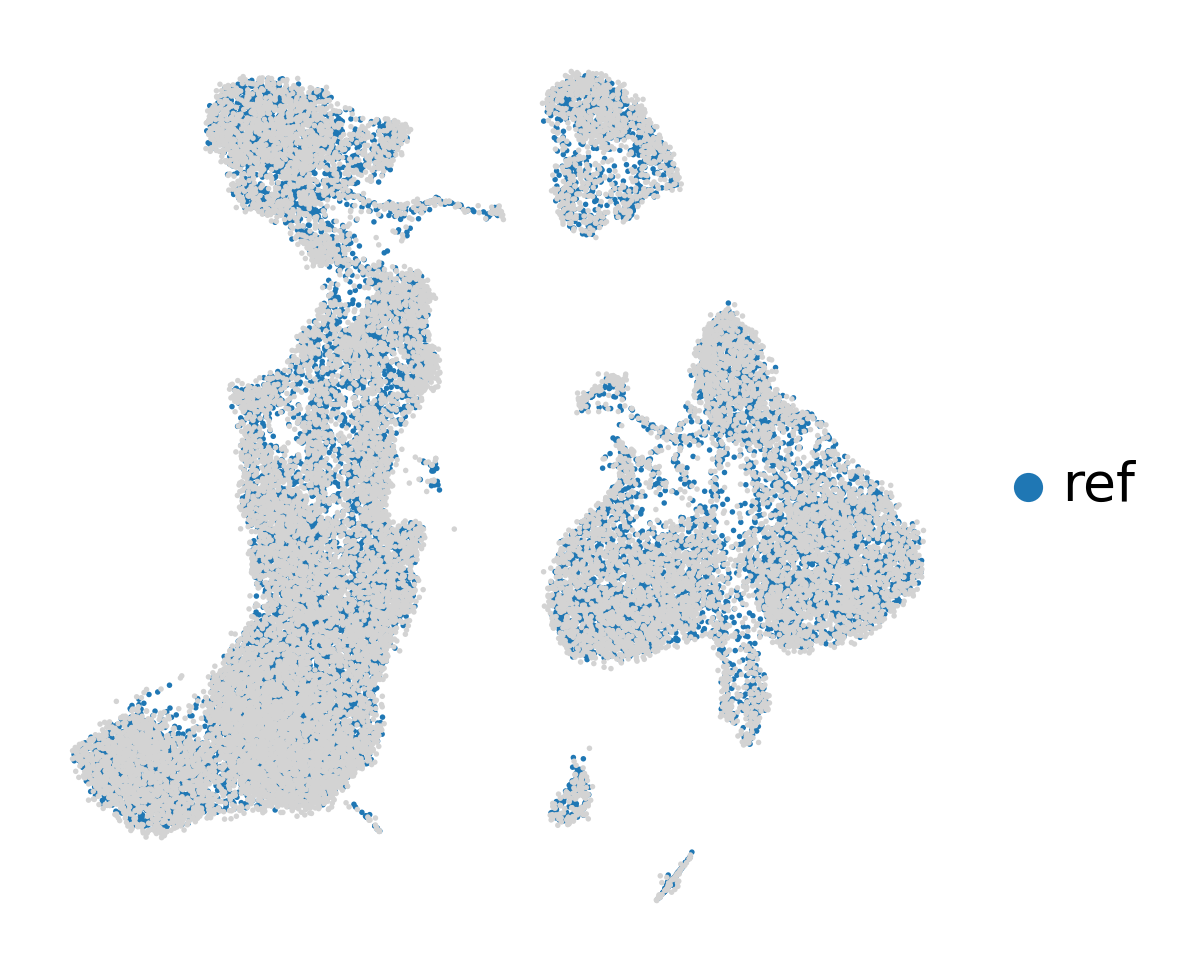

In [6]:
fig, axs = plt.subplots(figsize=(4,4))

adata_ref.obs["Reference vs query"] = "ref"

sc.pl.umap(adata_ref, ax=axs, show=False, frameon=False, color="Reference vs query")
sc.pl.umap(adata_query, ax=axs, show=False, frameon=False)

### Ingest dataset with different var_names

In [7]:
adata_query = sc.datasets.pbmc3k()
adata_query

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [8]:
len(adata_ref.var_names) == len(adata_query.var_names)

False

In [9]:
sc.pp.normalize_total(adata_query, target_sum=1e5)
sc.pp.log1p(adata_query)

In [10]:
sp._utils._map_query_to_ref(
    adata_ref,
    adata_query,
    query_basis_ref="X_pca"
)
sp.tl.ingest(adata=adata_query, adata_ref=adata_ref, embedding_method="umap")

335 out of 2000 genes from reference are missing in query dataset or have zero std in reference, their expressions in query will be set to zero


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


<AxesSubplot: xlabel='UMAP1', ylabel='UMAP2'>

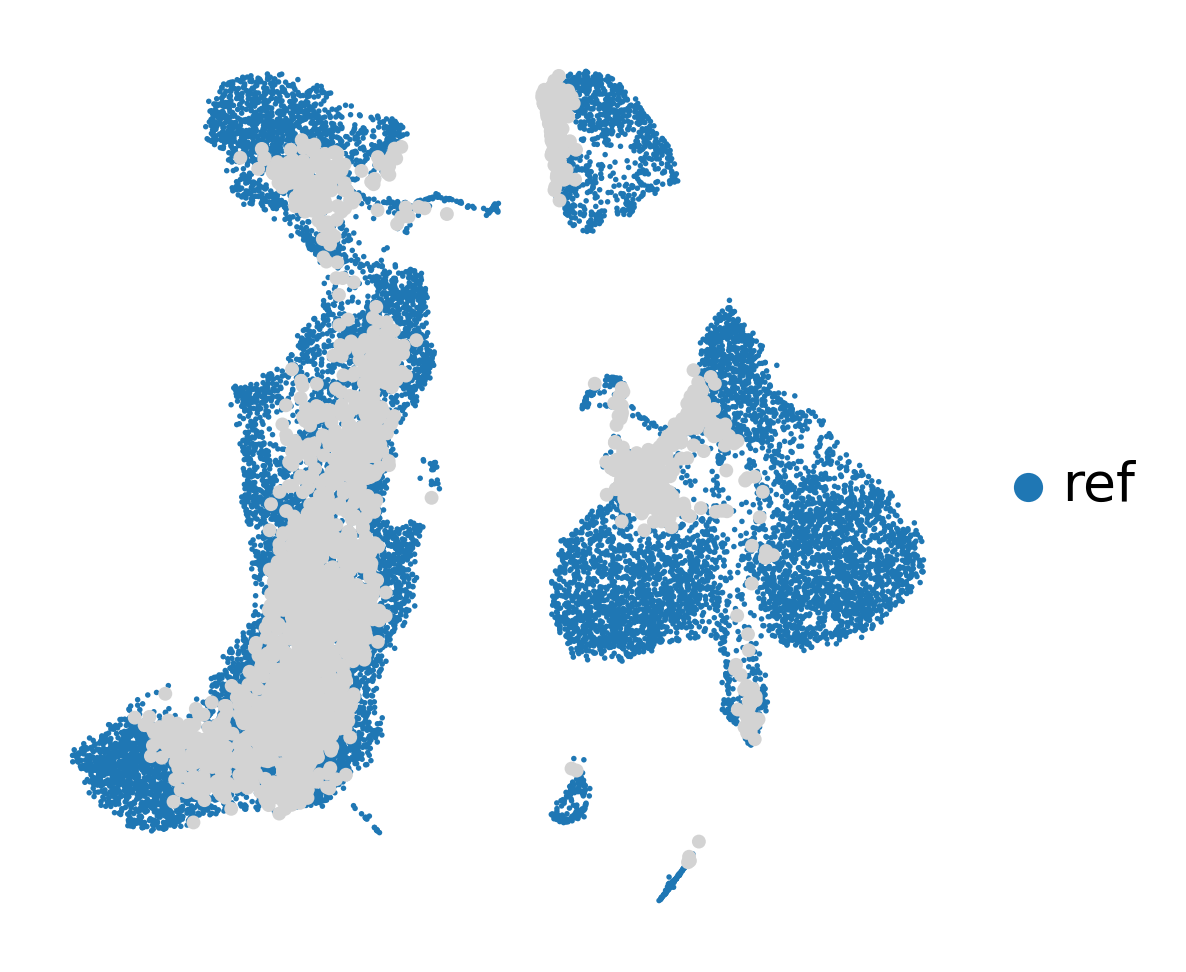

In [11]:
fig, axs = plt.subplots(figsize=(4,4))

sc.pl.umap(adata_ref, ax=axs, show=False, frameon=False, color="Reference vs query")
sc.pl.umap(adata_query, ax=axs, show=False, frameon=False)